# Dummy variable model for housing prices

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha_{NH[j]} + \beta * log(LA)_i \\
\alpha_j\sim Normal(1, 0.5),\space for\space j = 1...J\space neighbourhoods\\
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

In [205]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline

# Import dummy variable model
ols = pystan.StanModel(file = '../src/models/dummy_variable_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_158392d52f0d5ccb2cbf42a6f2271c61 NOW.


In [ ]:
## Generate fake data from the model

In [213]:
# Train/Test data
train = pd.read_csv('../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full[df_full['data_type'] == 'train']
test = df_full[df_full['data_type'] == 'test']

In [101]:
(test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

,log_lot_area
1460,0.482786
1461,0.879057
1462,0.818937
1463,0.188038
1464,-1.145324
...,...
2914,-2.980896
2915,-3.023283
2916,1.531843
2917,0.275694


In [69]:
# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()


# Create index variable for neighbourhood
#N_neighbourhood = len(df['Neighborhood'].unique())
#df['neighbourhood'] = df['Neighborhood'].astype('category').cat.codes+1


/Users/benjaminwee/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/benjaminwee/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

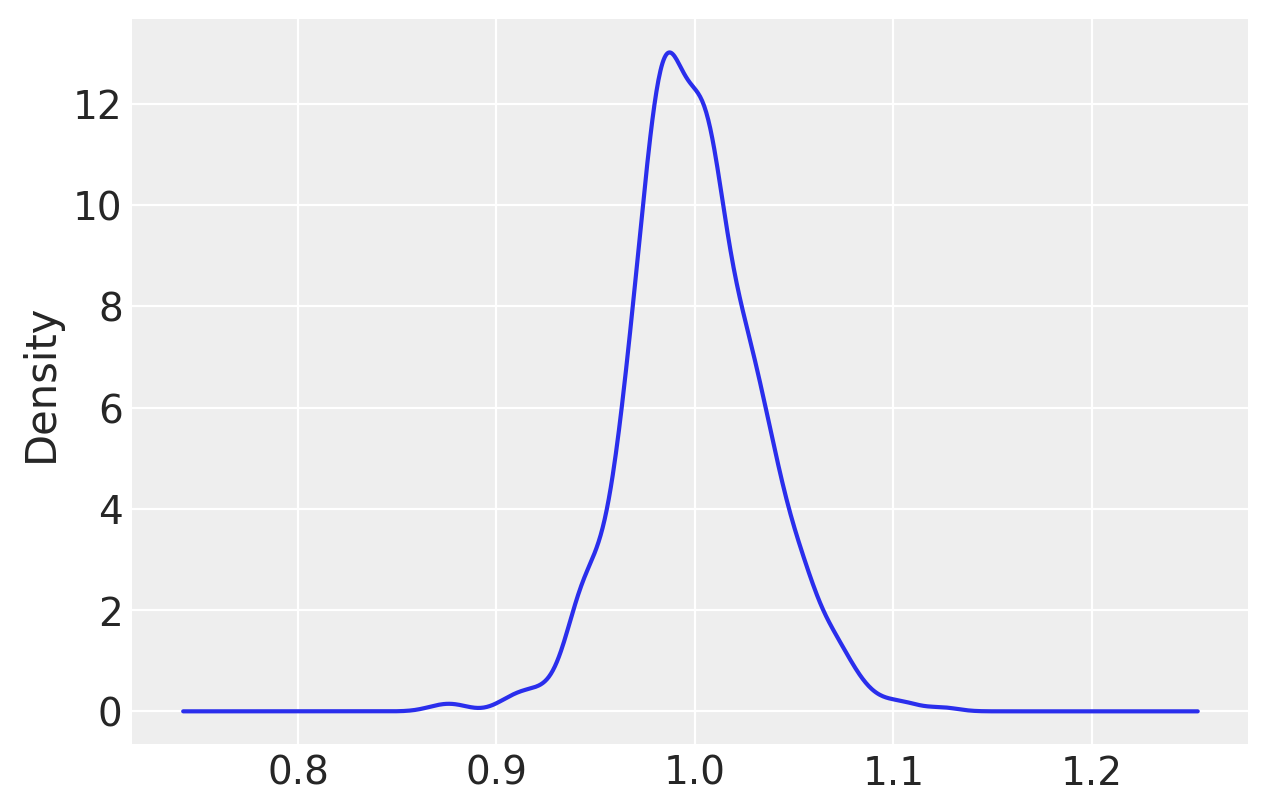

In [190]:
train['log_sales_price_std'].plot.kde()

In [91]:
len(df['Neighborhood'].unique())
len(train['Neighborhood'].unique())
len(test)
test['neighbourhood'].describe()
len(train['neighbourhood'].unique())
len(test['neighbourhood'].unique())
sum(test['neighbourhood'].isnull())
sum(test['log_sales_price_std'].isnull())

0

In [206]:
dv_data_check = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           alpha_sd = 0.5, 
           beta_sd = 0.5, 
           run_estimation = 0)

fit_dv_model_check = ols.sampling(data=dv_data_check)
dv_model_df_check = fit_dv_model_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Prior predictive checks

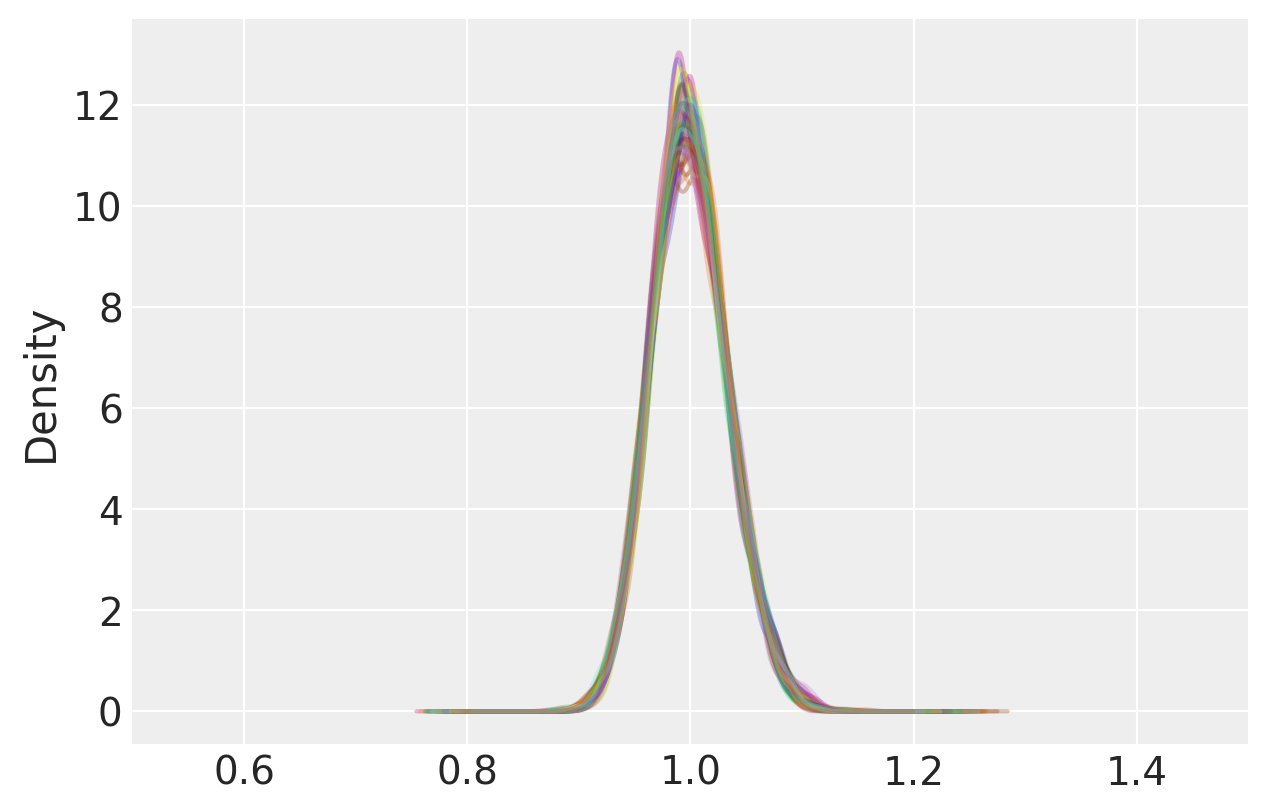

In [207]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

dv_model_df_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (0.5, 1.5));

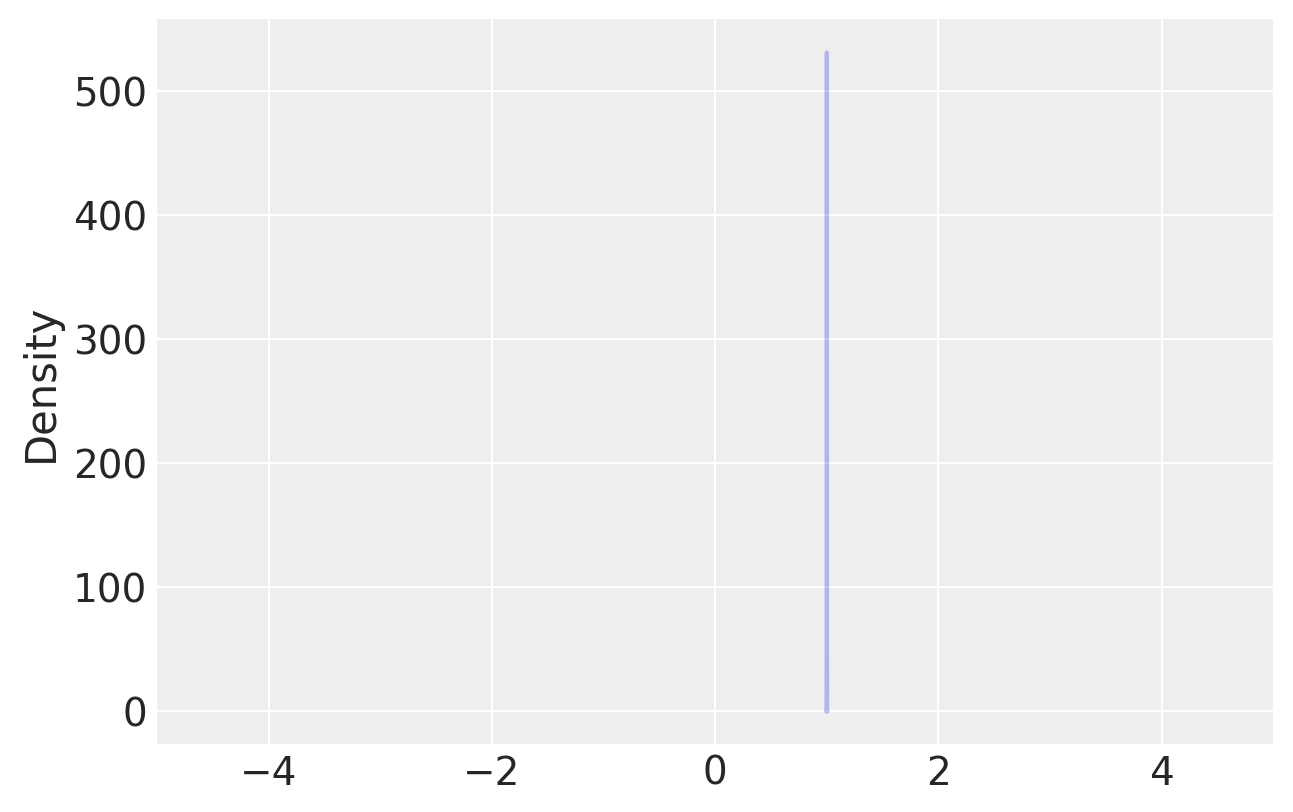

In [202]:
dv_model_df_check.filter(regex = 'y_hat').T.mean(axis = 0).plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-5, 5));

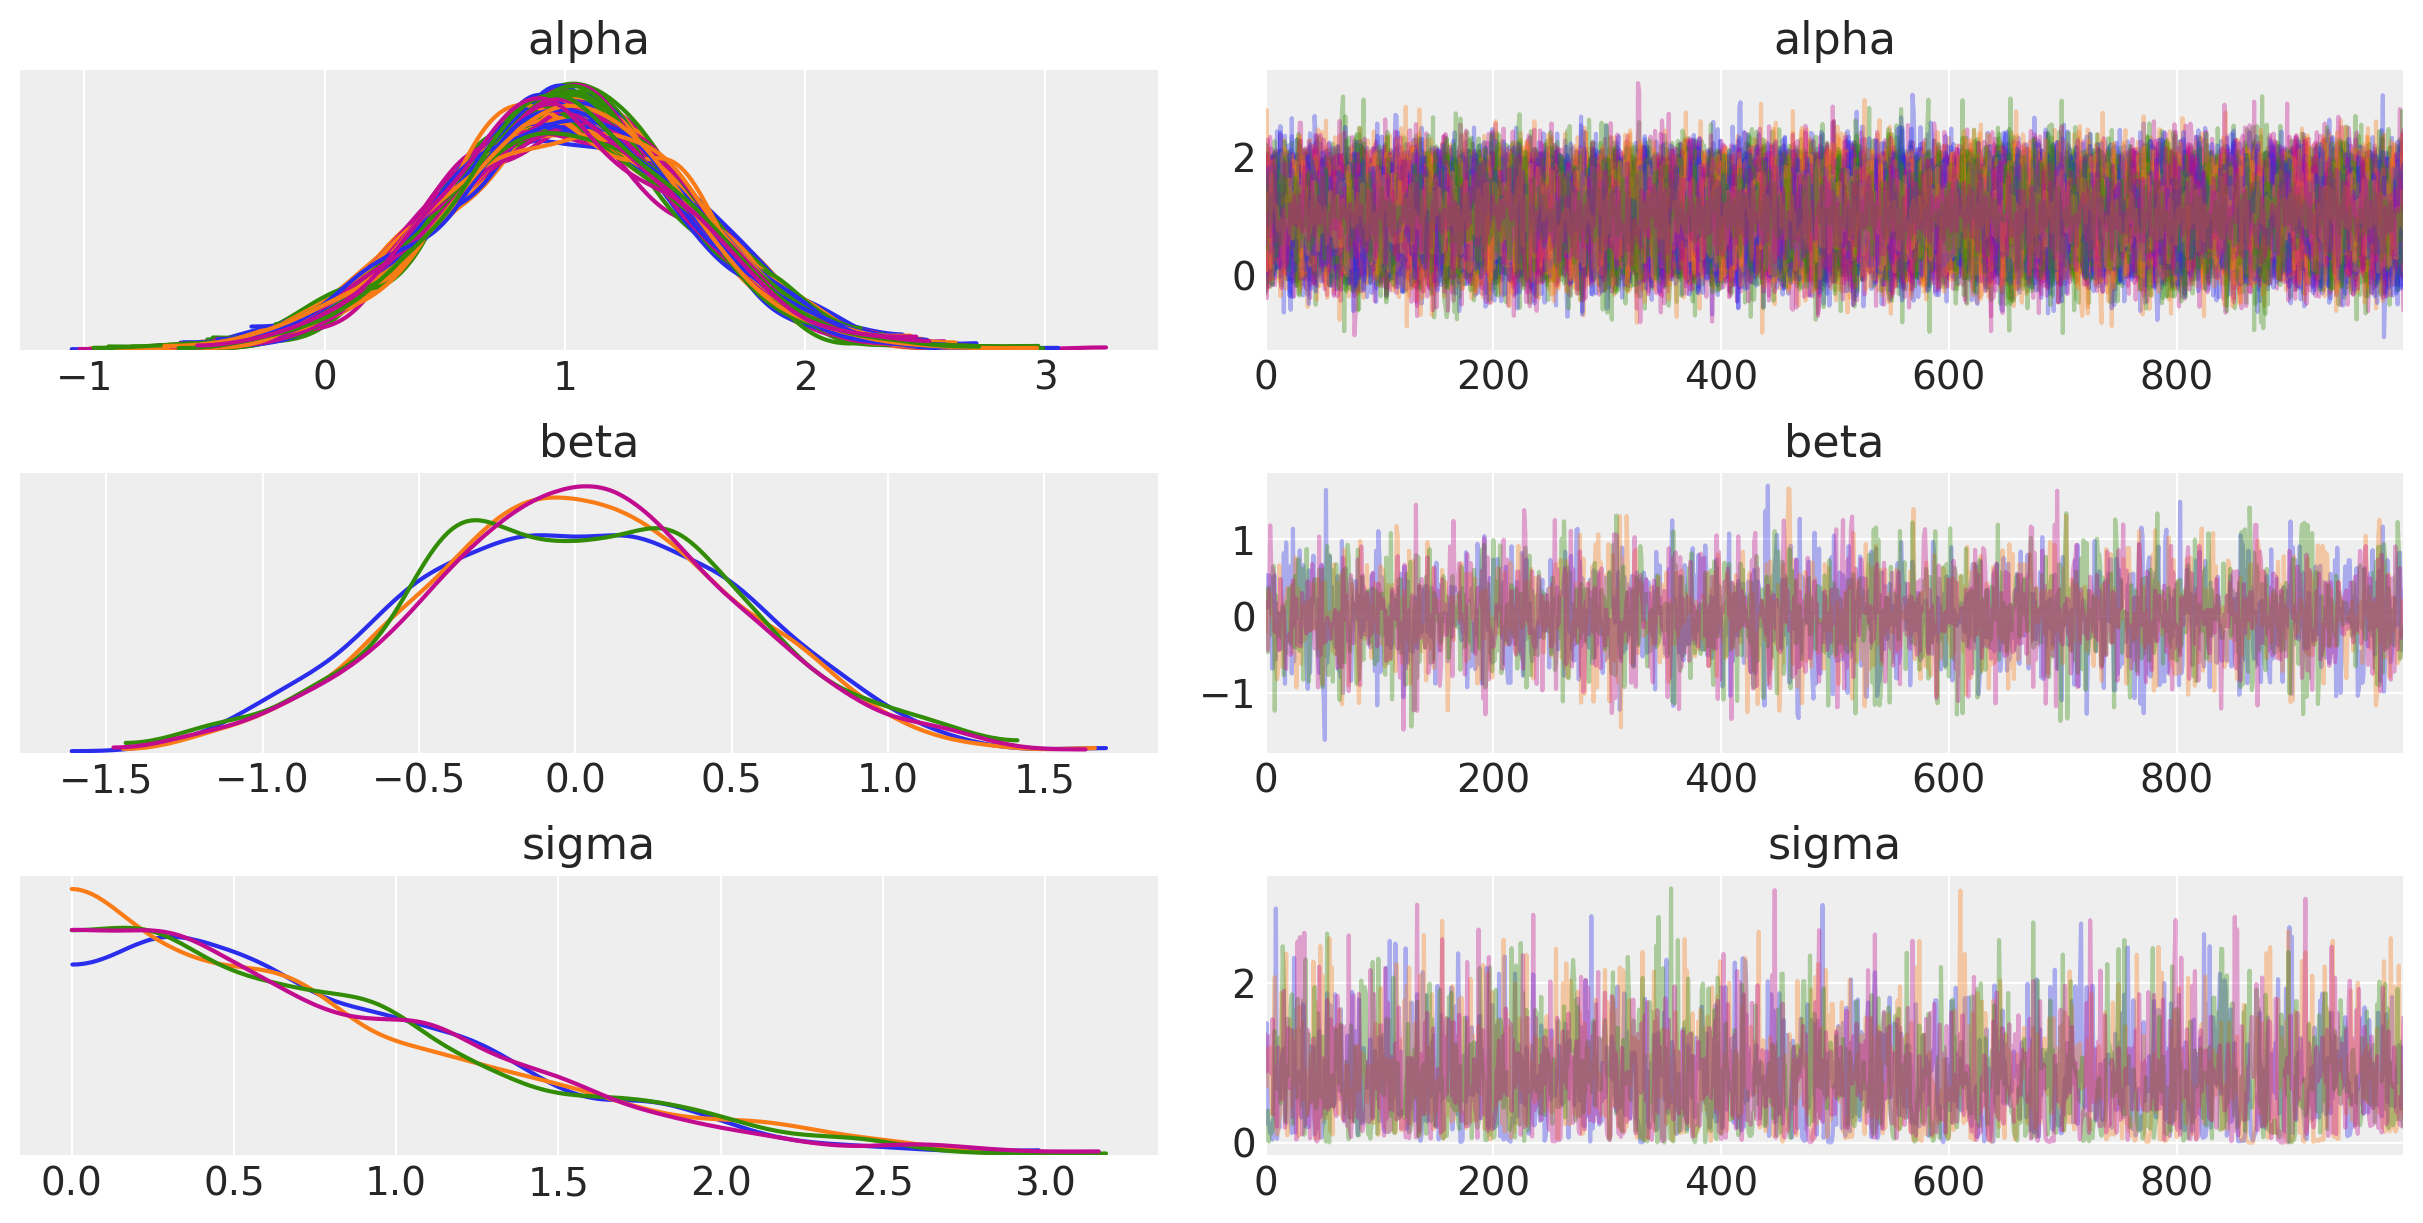

In [208]:
az.plot_trace(fit_dv_model_check, var_names=["alpha", "beta", "sigma"], compact = True);

In [ ]:
## Fit model on fake data and recapture known parameters (appendix?)

In [ ]:
## Fit model on real data

In [209]:
dv_data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           alpha_sd = 0.5, 
           beta_sd = 0.5, 
           run_estimation = 1)

fit_dv_model = ols.sampling(data=dv_data)
dv_model_df = fit_dv_model.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


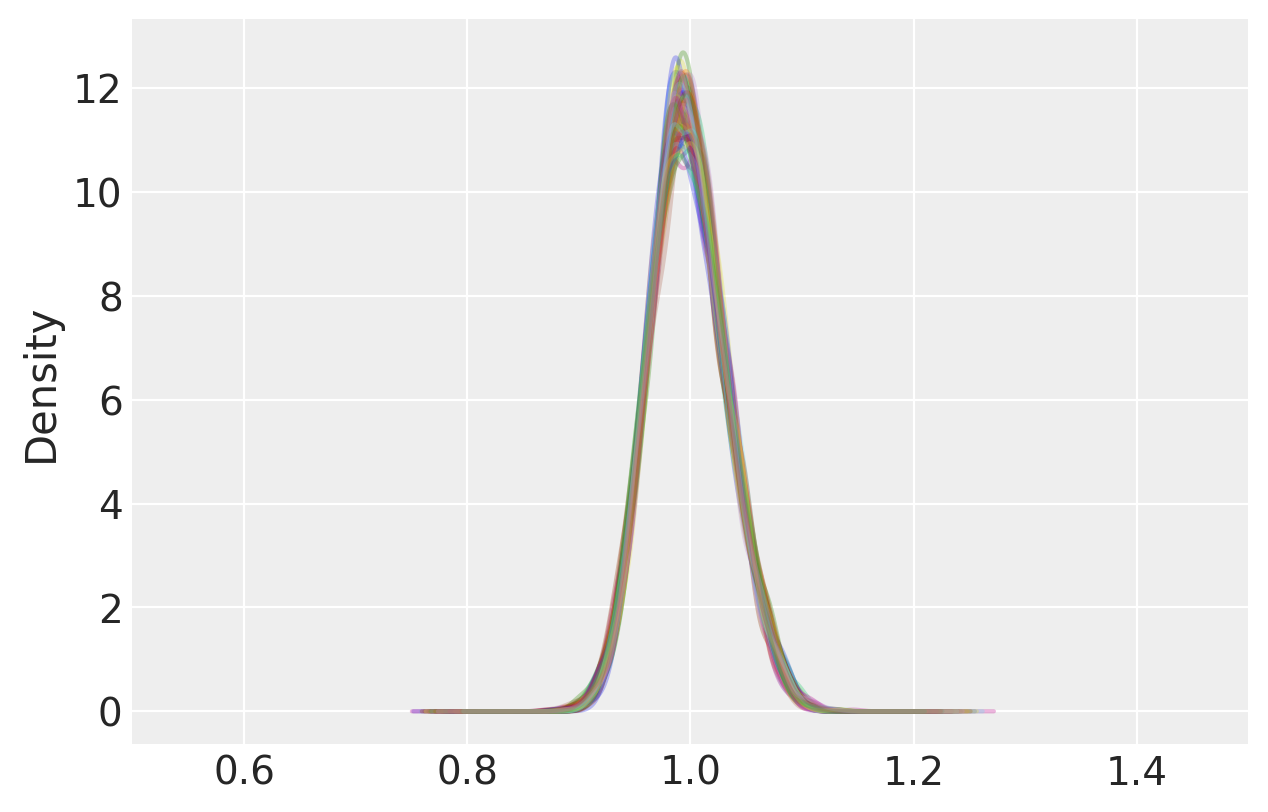

In [210]:
## Posterior predictive checks
dv_model_df.filter(regex = 'y_test').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (0.5, 1.5));

In [211]:
np.exp(dv_model_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()).describe()

count      1459.000000
mean     173135.811826
std       60112.452121
min       76339.824359
25%      130971.581672
50%      156791.552028
75%      197949.701807
max      471950.420832
dtype: float64

In [212]:
import math
((train['SalePrice'] - np.exp(dv_model_df.filter(regex = 'y_hat').mean(axis=0)*train['log_sales_price'].mean()).reset_index()[0])**2)

0       4.714720e+08
1       8.102905e+08
2       4.821852e+08
3       2.881565e+09
4       6.028434e+09
            ...     
1455    4.196506e+05
1456    3.234881e+08
1457    5.627965e+09
1458    9.943651e+00
1459    5.155372e+08
Length: 1460, dtype: float64